<h3> Useful links for this notebook:<br><br>
For converting the data:<br>
[1] https://www.kaggle.com/ilyamich/mfcc-implementation-and-tutorial <br>
[2] https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html <br>
[3] http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/ <br><br>

Data generators:<br>
[4] https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html <br>
[5] https://keras.io/utils/#sequence <br>

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import constants
import IPython.display as ipd  # To play sound in the notebook
np.random.seed(1001)
import os
from os import listdir
from os.path import isfile, join
import shutil
import IPython
import matplotlib
import seaborn as sns
from scipy.io import wavfile
from sklearn import preprocessing
import sys

In [2]:
data_loc="database/"
wav_path = data_loc+"audio_train/"
sr=44100
dataset = pd.read_csv(data_loc+"train.csv",header=0,names=['fname','label','verified'])
checkedDataset = dataset.loc[dataset.verified == 1,["fname","label"]]

In [3]:
def load_wav_file(name):
    _, b = wavfile.read(wav_path + name)
    assert _ == sr
    return b

checkedDataset['time_series'] = checkedDataset['fname'].apply(load_wav_file)
checkedDataset['nframes'] = checkedDataset['time_series'].apply(len)
checkedDataset=checkedDataset.reset_index()

In [4]:
# First, lets normalize the time series
# Perhaps we should address the warning given below?
for i in range(checkedDataset.shape[0]):
    c=checkedDataset.time_series[i]
#     checkedDataset.time_series[i] = c/np.linalg.norm(c)
    npmin=np.min(c)
    npmax=np.max(c)
    checkedDataset.time_series[i] = (c-npmin) / (npmax - npmin)

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in short_scalars
  


In [5]:
def split(x,y,keep):
    # test/train split
    # trainsz - size of train set to retain; eg 0.7
    trsize=int(x.shape[0] * keep)

    x_train=x[:trsize]
    x_val=x[trsize:] 

    y_train=y[:trsize] 
    y_val=y[trsize:] 
    
    return x_train,x_val,y_train,y_val

def encode(data, oneHot=False):
    # Encode labels into integers or onehot
    le = preprocessing.LabelEncoder()
    le.fit(data)
    trans = le.transform(data)
    if oneHot== True:
        ohlen = (len(set(trans)))
        eye=np.eye(ohlen)
        return np.array([eye[i] for i in trans])
    else:
        return trans

In [6]:
y=encode(checkedDataset.label.values, oneHot=True) # Get labels

In [7]:
xtr,xtst,ytr,ytst = split(checkedDataset.time_series.values,y, 0.8) # Split data into test/train
xval, xtst, yval, ytst = split(xtst, ytst, 0.5) # Split train into train/val

In [8]:
print ('Xtr shape: {}, Xtr[0] shape: {}. Note here that each row of Xtr is a list containing a time series!'.format(\
                                                                                                    xtr.shape, xtr[0].shape))
print (xtr.shape[0] + xval.shape[0] + xtst.shape[0])
print (y.shape)

Xtr shape: (2968,), Xtr[0] shape: (455112,). Note here that each row of Xtr is a list containing a time series!
3710
(3710, 41)


In [253]:
from keras.utils import Sequence
from scipy.signal import get_window
from scipy.fftpack import dct

class DataGen(Sequence):
    """
    See [4], [5] to understand how data generators work.
    CURRENTLY: This generator does work, but need to fix all MFCC getting related functions
    to properly deal with our data format (and finish some of them)
    """
    def __init__(self, x, labels, batch_size=5, FFT_size=2048, sr=44100):
        self.x, self.y= x, labels
        self.batch_size=batch_size
        self.FFT_size = FFT_size
        self.sr = sr
        
    def frame(self, audio, hop_size=10):
        """     
        Convert batch of time series to batch of audio frame
        Not currently working fully for batches, there is a cell below for
        playing with this.
        Taken from https://www.kaggle.com/ilyamich/mfcc-implementation-and-tutorial
        hop_size in ms
        """
        audio = np.pad(audio, int(self.FFT_size / 2), mode='reflect')
        frame_len = np.round(self.sr * hop_size / 1000).astype(int)
        frame_num = int((len(audio) - self.FFT_size) / frame_len) + 1
        frames = np.zeros((frame_num, self.FFT_size))

        for n in range(frame_num):
            frames[n] = audio[n*frame_len:n*frame_len+self.FFT_size]

        return frames
    
    def freq_domain(self, frames):
        # Convert audio frame into frequency domain
        window = get_window("hann", self.FFT_size, fftbins=True)
        wins=[]
        for frame in frames:
            wins.append(frame*window)
        return np.array(wins)
    
    def mfcc(self, frames):
        # Given frequency domains, get the MFCCs
        # Code for this function heavily based on https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
        NFFT=512
        nfilt=41
            
        num_ceps=41
        cep_lifter = 22 # cep_lifter is a parameter typically set to 22 in most implementations. 
                        #However, it refers to the dimensionality of the MFCC vector in the original formulation
            
        # First, we need to do an N point FFT on each of our frames to get the frequency spectrum
        mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
        pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
        
        # The final step before getting our MFCCs is to compute our filter banks
        low_freq_mel = 0
        high_freq_mel = (2595 * np.log10(1 + (self.sr / 2) / 700))  # Convert Hz to Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
        hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
        bin = np.floor((NFFT + 1) * hz_points / self.sr)

        fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
        for m in range(1, nfilt + 1):
            f_m_minus = int(bin[m - 1])   # left
            f_m = int(bin[m])             # center
            f_m_plus = int(bin[m + 1])    # right

            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        filter_banks = np.dot(pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
        filter_banks = 20 * np.log10(filter_banks)  # dB
        
        # Get MFCCs
        mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
        (nframes, ncoeff) = mfcc.shape
        n = np.arange(ncoeff)
        lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
        mfcc *= lift  #*
        
        # Mean normalization
        filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
        mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
        
        # For now, lets just try padding to length of 200
        print('mfcc shape before: ' + str(mfcc.shape))
        if mfcc.shape[0] > 200:
            mfcc = mfcc[:200,:]
        elif mfcc.shape[0] < 200:
            """
            ###################### NOTE - This is where the error is occuring. We need to pad
                                   the x axis to be 200, and keep the y at 40.
            """
            # Pad
            ###### NOTE NEED TO FIX PAD FUNCTION HERE - INCORRECT RESULTS
            num_zeros = 200 - mfcc.shape[0]
#             mfcc[0] = np.pad(mfcc[0], num_zeros, mode="edge")
            mfcc[0] = np.append(mfcc[0], [0]*num_zeros, axis=0)
            
        print('mfcc shape after: ' + str(mfcc.shape) + '\n')
        
        return mfcc

    def get_mfcc(self, batch):
        """ 
        Given a batch of data X, we have n rows. Each row contains
        a time series. Each of these time series needs to be converted to an audio frame and then
        to a frequency domain. We can then use that to filter and extract useful MFCC features. 
        See [1], [2], [3].
        """
        # Convert batch to MFCCs
        
        # First, get the frames
        frames=[]
        for series in batch:
            fr=self.frame(series) # Get the frame. Our X dimension will not be the same for all - take note.
            frames.append(fr)
        
        frames = np.array(frames)
        
        # Given frames, convert these to frequency
        freq = self.freq_domain(frames)
        
        # Given freq domain, we can finally extract the MFCCs
        mfccs = []
        for frame in freq:
            mfccs.append(np.array(self.mfcc(frame)))
        mfccs=np.array(mfccs)
        
        return mfccs
        
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def __getitem__(self,idx):
        tmp_x=self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Pass x batch to get transformed
        mfcc=self.get_mfcc(tmp_x)
        print (mfcc.shape)
#         batch_x=np.empty(shape=(self.batch_size,200,40))
        batch_x=[]
#         for i, row in enumerate(mfcc):
#             print (row.shape)
#             batch_x.append(row)
#         print (np.hstack(batch_x))
        return mfcc, batch_y

In [254]:
train=DataGen(xtr, ytr)
val=DataGen(xval,yval)
test=DataGen(xtst,ytst)

In [255]:
"""
Indicies: First 0: Batch 0
          Second 0: Training data (1 is labels)
          Third 0: Sample #
          Fourth: Row of sample
"""

train[0][0][2].shape
# data[0]

mfcc shape before: (201, 40)
mfcc shape after: (200, 40)

mfcc shape before: (201, 40)
mfcc shape after: (200, 40)

mfcc shape before: (201, 40)
mfcc shape after: (200, 40)

mfcc shape before: (137, 40)


ValueError: could not broadcast input array from shape (103) into shape (40)

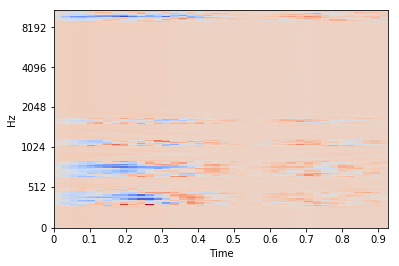

In [189]:
from librosa import display
librosa.display.specshow(data[35][0][0], x_axis='time', y_axis='mel')
# audio=data[30][0][0]
# plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
# plt.imshow(audio, aspect='auto', origin='lower');
# plt.show()

In [191]:
# Keras imports
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Embedding, BatchNormalization
from keras.layers import (Convolution1D, GlobalAveragePooling1D, Flatten,
                          GlobalMaxPool1D, MaxPool1D, Flatten, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import LeakyReLU, Bidirectional

In [192]:
cnet = Sequential([
    Convolution1D(200,4, padding="same", input_shape=(200, 40)),
    LeakyReLU(alpha=0.1),
    MaxPool1D(1),
    BatchNormalization(),
    
    Convolution1D(192,4, padding="same"),
    LeakyReLU(alpha=0.3),
    Convolution1D(192,4, padding="same"),
    LeakyReLU(alpha=0.3),
    MaxPool1D(8),
    
    Convolution1D(128,4, padding="same"),
    LeakyReLU(alpha=0.3),
    Convolution1D(128,4, padding="same"),
    LeakyReLU(alpha=0.3),
    MaxPool1D(8),
    BatchNormalization(),
    Flatten(),
#     LSTM(256, activation='relu'),
#     LSTM(256, activation='relu'),
  
#     Bidirectional(LSTM(256)),
    Dense(256),
    LeakyReLU(alpha=0.3),
    Dropout(rate=0.5),
    Dense(100),
    LeakyReLU(alpha=0.3),
    Dropout(rate=0.5),
    Dense(100),
    LeakyReLU(alpha=0.3),
    Dense(41, activation='softmax')
])

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0000001)

early = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=20,\
                      verbose=0, mode='auto')

cnet.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

print (cnet.summary())

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 200, 200)          32200     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200, 200)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 200, 200)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 200)          800       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 192)          153792    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 200, 192)          0         
___________________________________________________________

In [194]:
cnet.fit_generator(generator=train,
                    validation_data=val,
                    use_multiprocessing=True,
                    workers=6)

Epoch 1/1


ValueError: Error when checking input: expected conv1d_1_input to have 3 dimensions, but got array with shape (5, 1)